In [40]:
from sklearn.linear_model import ElasticNet
import pandas as pd
import xgboost as xgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, precision_score, label_ranking_average_precision_score, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn import svm, preprocessing
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# Reactome DB term to gene lists. Will be used to subset genes to see if any particular pathway is more informative than the rest
import pickle
with open('data/reactome_term_dicts.pickle', 'rb') as handle:
    reactome_dict = pickle.load(handle)
    
reactome_df = pd.DataFrame.from_dict(reactome_dict)
reactome_df.head()

In [71]:
reactome_df[reactome_df.term.str.contains('raf')]

,term,gene_list,n_genes
202,gap junction trafficking homo sapiens r-hsa-19...,"[AP2M1, CLTA, CLTB, CLTC, CLTCL1, DAB2, DNM1, ...",28
203,gap junction trafficking and regulation homo s...,"[AP2M1, CLTA, CLTB, CLTC, CLTCL1, DAB2, DNM1, ...",30
213,trafficking of glur2-containing ampa receptors...,"[AP2A1, AP2A2, AP2B1, AP2M1, AP2S1, GRIA1, GRI...",17
214,trafficking of ampa receptors homo sapiens r-h...,"[AKAP5, AP2A1, AP2A2, AP2B1, AP2M1, AP2S1, CAC...",31
240,intra-golgi traffic homo sapiens r-hsa-6811438,"[ALPP, ARF1, BET1L, COG1, COG2, COG3, COG4, CO...",44
242,intra-golgi and retrograde golgi-to-er traffic...,"[AGPAT3, ALPP, ARCN1, ARF1, ARF3, ARF4, ARF5, ...",179
244,copi-dependent golgi-to-er retrograde traffic ...,"[ARCN1, ARF1, ARF3, ARF4, ARF5, ARFGAP1, ARFGA...",81
248,copi-independent golgi-to-er retrograde traffi...,"[AGPAT3, BICD1, BICD2, DCTN1, DCTN2, DCTN3, DC...",29
255,membrane trafficking homo sapiens r-hsa-199991,"[AGPAT3, AKT1, AKT2, ALPP, ANK1, ANK2, ANK3, A...",420
259,intraflagellar transport homo sapiens r-hsa-56...,"[CLUAP1, DYNC2H1, DYNC2LI1, DYNLL1, DYNLL2, DY...",41


In [72]:
apop_genes = reactome_df.loc[reactome_df.term=='apoptosis homo sapiens r-hsa-109581']['gene_list'].values
apop_genes = list(apop_genes[0])
dna_genes = reactome_df.loc[reactome_df.term=='dna repair homo sapiens r-hsa-73894']['gene_list'].values[0]

braf_genes = reactome_df.loc[reactome_df.term=='raf activation homo sapiens r-hsa-5673000']['gene_list'].values[0]

In [5]:
dna_genes[0:5]

['ABL1', 'ACTB', 'ACTL6A', 'ACTR5', 'ACTR8']

In [6]:
merged = pd.read_hdf('merged_depmap.h5', 'df')

In [30]:
merged.shape

(401, 19341)

In [20]:
with open('gene_names.txt', 'r') as f:
    gene_names = f.read().splitlines()
gene_names

with open('drug_names.txt', 'r') as f:
    drug_names = f.read().splitlines()
drug_names

['5-FLUOROURACIL',
 '681640',
 'ACY-1215',
 'AFATINIB',
 'AGI-6780',
 'AICAR, N1-(B-D-RIBOFURANOSYL)-5-AMINOIMIDAZOLE-4-CARBOXAMIDE',
 'AKT INHIBITOR VIII, KIN001-102',
 'ALECTINIB',
 'ALISERTIB',
 'AT7867',
 'AUY922',
 'AVAGACESTAT',
 'AXITINIB',
 'AZD6482',
 'AZD7762',
 'AZD8055',
 'BICALUTAMIDE',
 'BIX02189',
 'BLEOMYCIN (50 UM)',
 'BMS-345541',
 'BMS-536924',
 'BOSUTINIB',
 'BRIVANIB',
 'BX-795',
 'BX-912',
 'CABOZANTINIB',
 'CANERTINIB',
 'CCT007093',
 'CCT018159',
 'CD532',
 'CHIR-99021',
 'CISPLATIN',
 'CP-724714',
 'CP466722',
 'CYTARABINE',
 'DABRAFENIB',
 'DOCETAXEL',
 'DORAMAPIMOD',
 'EEF2K INHIBITOR, A-484954',
 'EHT 1864',
 'ELESCLOMOL',
 'ENZASTAURIN',
 'ETP-45835',
 'FORETINIB',
 'FR-180204',
 'GDC-0941',
 'GEFITINIB',
 'GEMCITABINE',
 'GENENTECH CPD 10',
 'GSK1904529A',
 'GSK2126458',
 'GSK269962A',
 'GSK429286A',
 'GW 441756',
 'GW-2580',
 'I-BET-762',
 'IC-87114',
 'IDELALISIB',
 'IKK-2-INHIBITOR-V',
 'IOX2',
 'ISPINESIB MESYLATE, SB-715992',
 'JNJ-38877605',
 'JNK IN

In [45]:
def run_model(df, model, drugname, gene_list, plot=False):
    subset_genes = list(sorted(set(gene_list).intersection(set(df.columns.values))))
    X = df[subset_genes].copy()
    y = df[drugname].values.reshape(-1, 1)
    X = preprocessing.StandardScaler(with_mean=False).fit_transform(X)
    y = preprocessing.StandardScaler(with_mean=False).fit_transform(y).ravel()
#     print(y)
#     return
#     poly = PolynomialFeatures(degree=2)
#     X = poly.fit_transform(X)
     
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.33, 
        shuffle=False, 
        random_state=69,
    )
    
#     print(X_train.shape, y_train.shape)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    error = mean_squared_error(y_test, preds)
    print(f"R^2 {r2_score(y_test, preds)}")
#     print(np.max(model.coef_))
    if plot:
        sns.regplot(y_train, model.predict(X_train), label='training set')
        sns.regplot(y_test, preds, label='test set')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.legend()
        plt.suptitle(f"{drugname} : RMSE = {error}")
    return error

R^2 0.11882178225251971


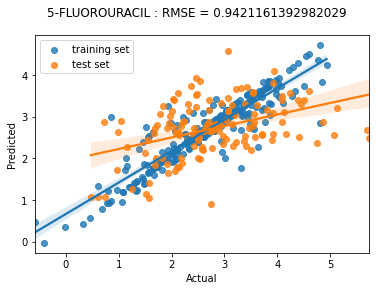

In [46]:
run_model(
    merged, 
    model=svm.SVR(gamma=0.001, C=10.),
    drugname=drug_names[0],
    gene_list=apop_genes,
    plot=True
    );

R^2 0.14181643600780192


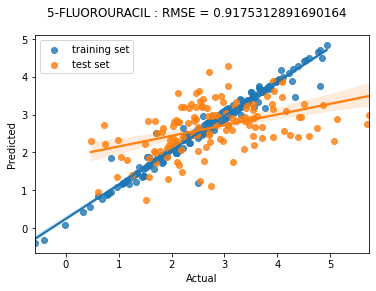

In [47]:
run_model(
    merged, 
    model=svm.SVR(gamma=0.001, C=10.),
    drugname=drug_names[0],
    gene_list=dna_genes,
    plot=True
);

R^2 -0.01539289193552884


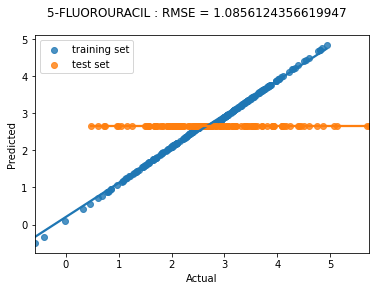

In [48]:
run_model(
    merged, 
    model=svm.SVR(gamma=0.001, C=10.),
    drugname=drug_names[0],
    gene_list=gene_names,
    plot=True
);

R^2 0.14893716080831088


0.9099181303063186

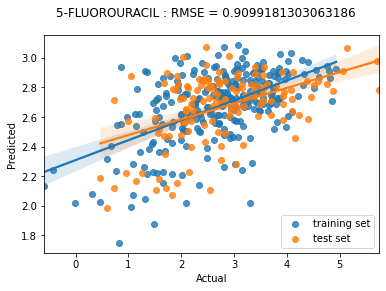

In [49]:
run_model(
    merged, 
    model=ElasticNet(
        random_state=0,
        normalize =False,
        max_iter=100000, 
        fit_intercept=False,
        l1_ratio=.5,
        alpha=0.5,
        selection='random'
    ),
    drugname=drug_names[0],
    gene_list=apop_genes,
    plot=True
)

R^2 0.11121831155552597


1.016802846073988

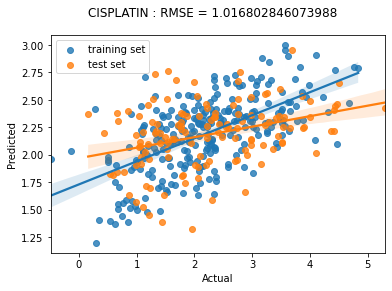

In [53]:
run_model(
    merged, 
    model=ElasticNet(alpha=.2, random_state=0, normalize =False, max_iter=100000),
    drugname='CISPLATIN',
    gene_list=dna_genes,
    plot=True
    )

# Gradient boosted decision trees

XGBoost parameters


https://xgboost.readthedocs.io/en/latest/parameter.html

In [123]:
# fit model no training data
params = dict(
    # general params
    booster='gbtree',
    gpu_id=0,
    seed=100,
    # regularization
    reg_alpha=1, 
    reg_lambda=5,
    num_parallel_tree = 12, 
#     num_boost_round = 16,
    tree_method='gpu_hist',
    max_bin=256,
    objective='reg:squarederror',
    eval_metric='rmse',
    learning_rate=0.05,
    max_depth=5, 
    min_child_weight=1,
#     gamma=0,
    subsample=.5, # use half of data to resample
#     colsample_bytree=.8,
)

def create_importance_model(df, drugname, subset_list, save_name, plot=False):
    subset_genes = list(sorted(set(subset_list).intersection(set(df.columns.values))))
#     X = df[subset_genes]
#     y = df[drugname]
#     X = preprocessing.StandardScaler().fit(X).transform(X)
    
    X = df[subset_genes].copy()
    y = df[drugname].values.reshape(-1, 1)
#     print(df[drugname].values)
    X = preprocessing.StandardScaler(with_mean=False).fit_transform(X)
#     y = preprocessing.StandardScaler(with_mean=False).fit_transform(y).ravel()
#     print(y)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.33, 
        shuffle=True, 
        random_state=69,
    )

    
    # organize data into xgb data matrix
    all_data = xgb.DMatrix(data=X, label=y)
    train = xgb.DMatrix(data=X_train, label=y_train)
    test = xgb.DMatrix(data=X_test, label=y_test)

    # add gene names as feature labels
    all_data.feature_names = subset_genes
    train.feature_names = subset_genes
    test.feature_names = subset_genes
    
    num_round = 100000
    results = dict()
    model = xgb.train(
        params, train, num_round,
        verbose_eval=False,
        early_stopping_rounds=100,
        evals=[(train, 'train'), (test, 'valid')],
        evals_result=results,
        
    )  
    
    feature_scores = model.get_fscore()
    s = pd.Series(list(feature_scores.values()), index=feature_scores)
#     print(s.sort_values(ascending=False).head(5))
    
    
    #trained 
    t_preds = model.predict(train, ntree_limit=model.best_ntree_limit)

    #predictions
    preds = model.predict(test)
    error = mean_squared_error(y_test, preds)
    error = "{0:.3f}".format(np.sqrt(error))
    r2 = r2_score(y_test, preds)
    print(f"MSE: {error}")
    print(f"R^2 {r2}")
    if plot:
        
        # create plot of training and performance

        # plot training over time
        x_axis = range(0, len(results['train']['rmse']))
        plt.figure(figsize=(12, 6))
        plt.subplot(121)
        plt.plot(x_axis, results['train']['rmse'], label='Train')
        plt.plot(x_axis, results['valid']['rmse'], label='Test')
        plt.legend()

        # plot projections vs actual
        plt.subplot(122)
        sns.regplot(y_train, t_preds, label='training')
        sns.regplot(y_test, preds, label='prediction')
        plt.legend()
        plt.suptitle(f"{drugname} {save_name} : RMSE = {error}, r2= {r2}")
    return error, r2

In [68]:
print(list(i for i in drug_names if i.startswith('PL')))

['PLX-4720']


MSE: 1.614
R^2 0.3587627488513706
MSE: 1.712
R^2 0.27799499933499616


('1.712', 0.27799499933499616)

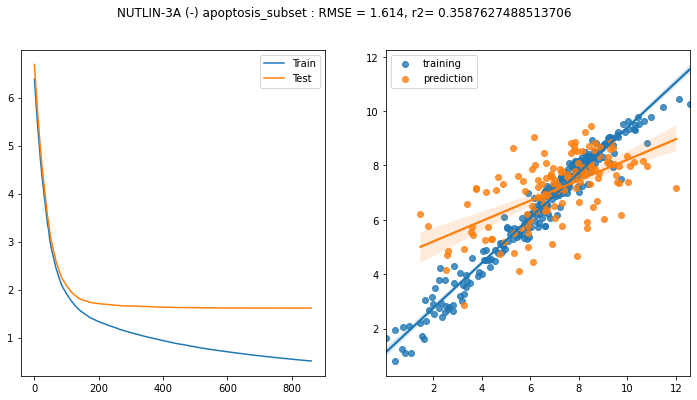

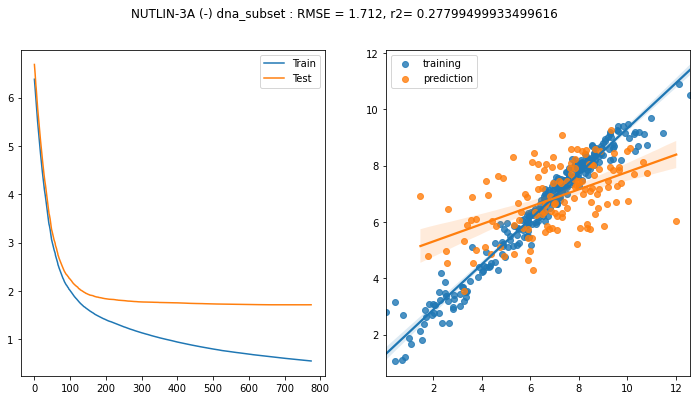

In [124]:
dn = 'NUTLIN-3A (-)'
create_importance_model(
    merged, dn, apop_genes, 'apoptosis_subset', True
)

create_importance_model(
    merged, dn, dna_genes, 'dna_subset', True
)

In [84]:
drugs = ['NUTLIN-3A (-)', 'PLX-4720', 'CISPLATIN']
gene_sets = [braf_genes, dna_genes, apop_genes]

rmse_output, r2_output = [], []
for i in drugs:
    r2, rmse = [], []
    for j in gene_sets:
        rmse_l, r2_l = create_importance_model(
            merged, i, j, 'apoptosis_subset'
        )
        r2.append(r2_l)
        rmse.append(rmse_l)
    rmse_output.append(rmse)
    r2_output.append(r2)


MSE: 1.984
R^2 0.030415911781213167
MSE: 1.712
R^2 0.27799499933499616
MSE: 1.614
R^2 0.3587627488513706
MSE: 1.560
R^2 0.10113200799492073
MSE: 1.566
R^2 0.09390385476069052
MSE: 1.520
R^2 0.14576002688408607
MSE: 2.058
R^2 0.08507281196749816
MSE: 1.985
R^2 0.14851896595465408
MSE: 1.998
R^2 0.1380277763038874


In [78]:
np.array(output, dtype=float)

array([[1.984, 1.712, 1.614],
       [1.56 , 1.566, 1.52 ]])

<AxesSubplot:>

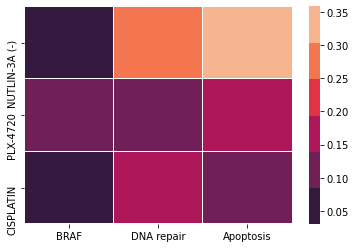

In [85]:
sns.heatmap(
    np.array(r2_output, dtype=float), 
    yticklabels=drugs, 
    xticklabels=['BRAF', 'DNA repair', 'Apoptosis'],
    linewidths=0.01,
    cmap= sns.color_palette("rocket")
)

Epoch [10000/10000], Loss train: 1.9749e+00, test 8.1765e+00                         
	 2.204
r2 = -0.04933838743336594


2.2039614

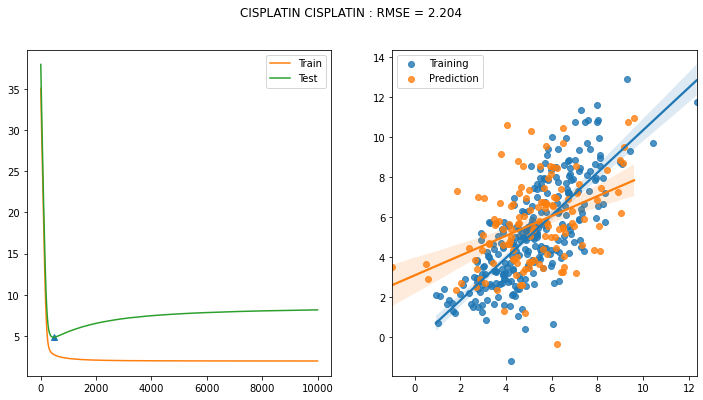

In [120]:
import torch
import torch.nn as nn
class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)
        self.dropout = nn.Dropout(p=0.1)
        self.Tanh = nn.Tanh()
    def forward(self, x):
        y_pred = self.linear1(x)
#         y_pred = self.dropout(y_pred)
#         y_pred = self.dropout(self.Tanh(y_pred))
        y_pred = self.linear2(y_pred)
#         y_pred = self.dropout(y_pred)

        return y_pred
    
import time
from copy import deepcopy
def run_nn(df, gene_list, save_name, drugname, verbose=False):
    torch.cuda.empty_cache()
    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     print(drugname)
#     dev = 'cpu'
#     print('Using device:', dev)
    ib = list(set(gene_list).intersection(set(df.columns.values)))
    X = df[ib].values
    y = df[drugname].values.reshape(-1,1)
    X = preprocessing.StandardScaler().fit(X).transform(X)
#     y = preprocessing.StandardScaler().fit(y).transform(y)
#     poly = PolynomialFeatures(degree=2)
#     X = poly.fit_transform(X)
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            test_size=0.33, 
            shuffle=True, 
            random_state=69,
        )
    except:
        return
    
    dtype = torch.float32
    X_train = torch.tensor(X_train, dtype=dtype,  device=dev)
    X_test = torch.tensor(X_test, dtype=dtype,  device=dev)

    y_train = torch.tensor(y_train, dtype=dtype,  device=dev)
    y_test = torch.tensor(y_test, dtype=dtype,  device=dev)

#     print(X_train.shape, y_train.shape)
    D_in, D_out = X_train.shape[1], y_train.shape[1]
    H1 = int((D_in+D_out)/2)
#     H1 = 100
    model = Net(D_in, H1, D_out)
    model.to(dev)
    model.float()
    criterion = nn.MSELoss(reduction='mean')
    
#     optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
    
#     optimizer = torch.optim.Adam(
#         model.parameters(),
#         lr=1e-5,
#         betas=(0.9, 0.999), 
#         eps=1e-08, 
#         weight_decay=0,
#         amsgrad=False
#     )
#     optimizer = torch.optim.SGD(
#         model.parameters(),
#         lr=0.001,
#         momentum=0.5
#     )
    optimizer = torch.optim.ASGD(
        model.parameters(), lr=0.001, lambd=0.001, 
        alpha=0.0, t0=1000.0, weight_decay=0.
    )

    n_epoch = 10000
    eval_per_epoch = n_epoch
    prev_loss = np.inf
    steps_wo_impro = 0
    best_state = deepcopy(model.state_dict())
    best_epoch = 0
    st = time.time()
    train, valid = [], []
    for epoch in range(n_epoch):
        if steps_wo_impro > eval_per_epoch:
#             print(f"Early stopping at {epoch}")
            break
        model.train()
        
        # use original method
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        if torch.isnan(loss):
            break        
        loss.backward()
        optimizer.step()
        with torch.no_grad():
        
            test_loss = criterion(model(X_test), y_test).item()

            train.append(loss.item())
            valid.append(test_loss)

            if test_loss < prev_loss:
                prev_loss = deepcopy(test_loss)
                steps_wo_impro = 0
                best_state = deepcopy(model.state_dict())
                best_epoch = epoch
            else:
                steps_wo_impro += 1
    #         if epoch < 1000:
    #             steps_wo_impro = 0
    #             prev_loss = np.inf
            if verbose:
                if (epoch+1) % eval_per_epoch == 0:
                    print(
                        'Epoch [{}/{}], Loss train: {:2.4e}, test {:2.4e} \
                        '.format(epoch+1, n_epoch, loss.item(), test_loss)
                    )
#     print(f'time : {time.time()-st}')
    del model
    
    test_model = Net(D_in, H1, D_out)
    test_model.load_state_dict(best_state)
    test_model.float()
    test_model.to(dev)
    test_model.eval()
    
    train_pred = test_model(X_train).cpu().detach().numpy()
    train_actual = y_train.cpu().detach().numpy()
    
    error = mean_squared_error(train_pred, train_actual)
    error = "{0:.3f}".format(np.sqrt(error))
#     print(f"Best epoch = {best_epoch} with error = {prev_loss} {np.sqrt(prev_loss)}")
#     print(f"\t {error}")  
    
    test_pred = test_model(X_test).cpu().detach().numpy()
    test_actual =  y_test.cpu().numpy()
    error = mean_squared_error(test_pred, test_actual)
#     return np.sqrt(error)
    error = "{0:.3f}".format(np.sqrt(error))
    r2 = r2_score(np.array(test_actual).flatten(), 
                  np.array(test_pred).flatten())
    print(f"\t {error}")  
    print(f"r2 = {r2}")  
    
    # simple plot
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    x_axis = range(0, len(train))
    plt.plot(best_epoch, prev_loss, marker='^')
    plt.plot(x_axis, train, label='Train')
    plt.plot(x_axis, valid, label='Test')
    plt.legend()

    plt.subplot(122)
    sns.regplot(train_pred[:,0], train_actual[:,0], label='Training')
    sns.regplot(test_pred[:,0], test_actual[:,0], label='Prediction')
    plt.legend()
    plt.suptitle(f"{drugname} {save_name} : RMSE = {error}")
#     plt.close()
    return np.sqrt(mean_squared_error(test_pred, test_actual))
run_nn(merged, apop_genes, 'CISPLATIN', 'CISPLATIN', True) 